In [1]:
import torch
import train
import model
import numpy as np
import csvLoader as cl
import visualizer as vs
import dataLoader as dl
import dataAugmentation as da
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

GPU mode: True
Len of train csv: 7049
All Valid Shape - (2140, 31)
Auto Fill Shape - (7049, 31)
Missing Only Shape - (4909, 31)
Loading Dataset...
Size of Image Array - 2140
Randomly Visualizing...


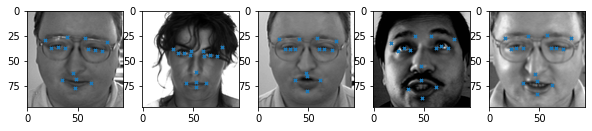

In [2]:
TRAIN_CSV_PATH = 'facial-keypoints-detection/training/training.csv'
TEST_CSV_PATH = 'facial-keypoints-detection/test/test.csv'

USE_GPU, device = train.check_GPU()
print('GPU mode: {}'.format(USE_GPU))

train_csv = cl.load_csv(TRAIN_CSV_PATH)

print(f'Len of train csv: {len(np.array(train_csv.Image))}')
csv_allValid, csv_autoFill, csv_missingOnly = cl.clean_csv(train_csv)

print('Loading Dataset...')
autoFill_dataset = dl.FacialKptsDataSet(csv_allValid)
print('Randomly Visualizing...')
vs.rand_vis_dataset(autoFill_dataset, 5)

In [3]:
autoFillTrain, autoFillVal = dl.getTrainValidationDataSet(csv_allValid, 0.85)
print('Loading training/val set...')
train_dataset = dl.FacialKptsDataSet(autoFillTrain)
val_dataset = dl.FacialKptsDataSet(autoFillVal)

Loading training/val set...
Size of Image Array - 1819
Size of Image Array - 321


Size of Image Array - 1819
Visualizing dataset #0...


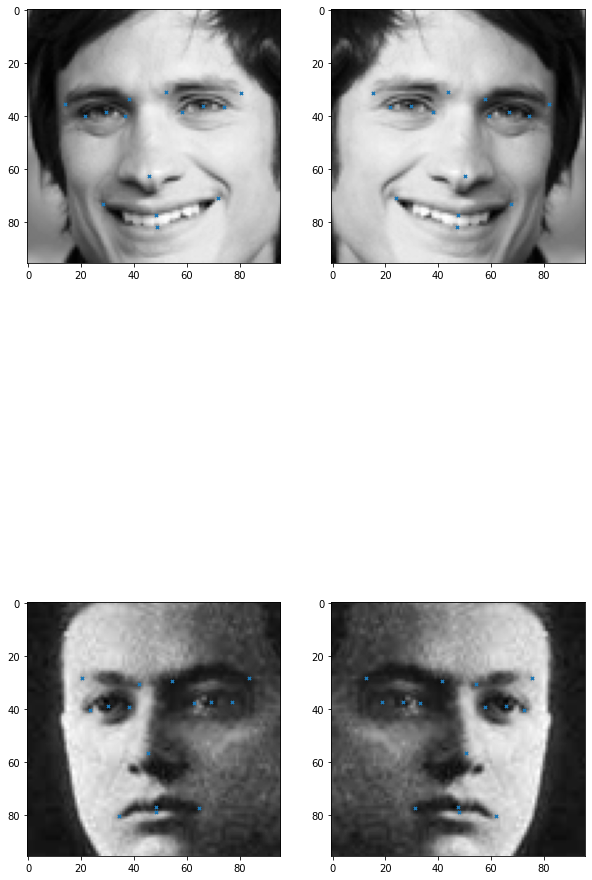

Size of Original set - 2140
Size of Mirror Aug sets list - 1


In [4]:
# Mirror
mirror_set = da.create_augs_from_transform(autoFillTrain, da.mirror, params=[None])
vs.rand_vis_compare_orig_augset(train_dataset, mirror_set, 2)
print('Size of Original set - {}\nSize of Mirror Aug sets list - {}'.format(len(autoFill_dataset), len(mirror_set)))

Size of Image Array - 1819
Size of Image Array - 1819
Visualizing dataset #0...
Visualizing dataset #1...


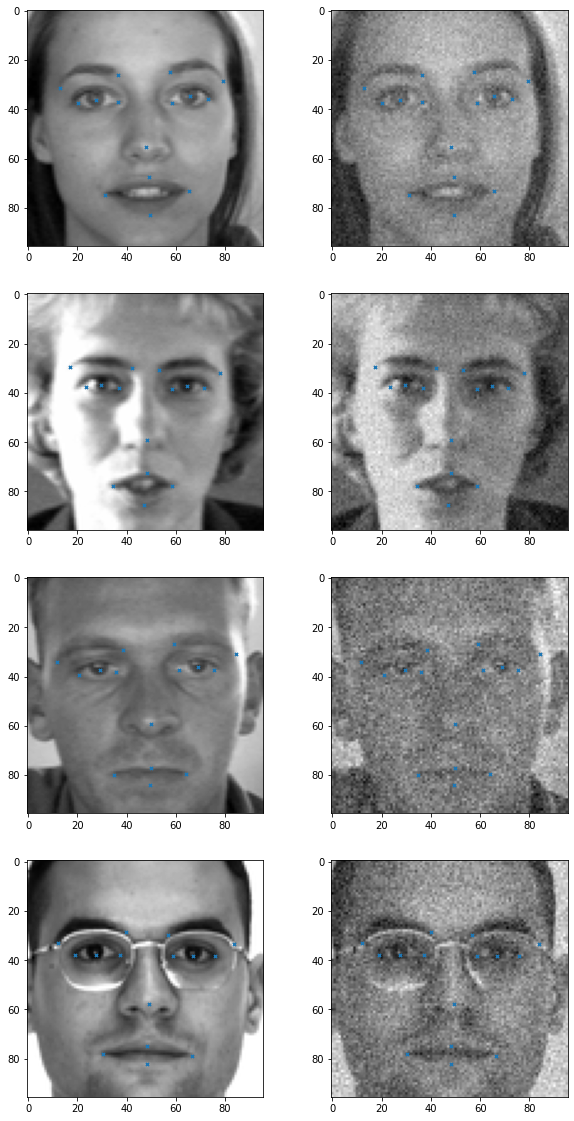

In [5]:
# Add Noise
noise_set = da.create_augs_from_transform(autoFillTrain, da.add_noise, params=[0.1, 0.2])
vs.rand_vis_compare_orig_augset(train_dataset, noise_set, 2)

Size of Image Array - 1819
Size of Image Array - 1819
Visualizing dataset #0...
Visualizing dataset #1...


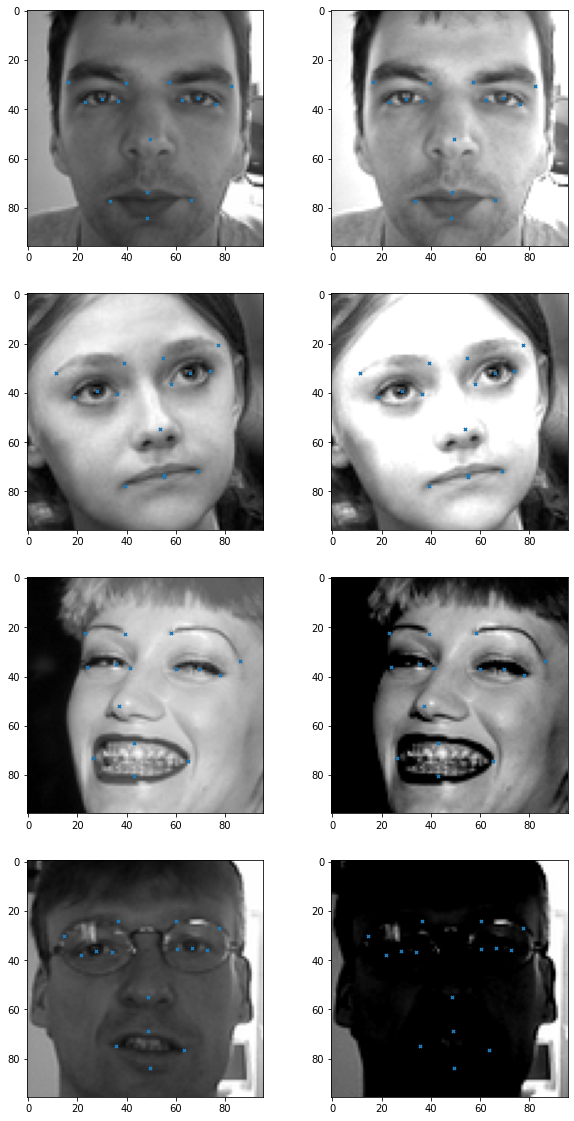

In [6]:
# Brightness Trim
brightTrim_set = da.create_augs_from_transform(autoFillTrain, da.brightness_trim, params=[0.7, -0.7])
vs.rand_vis_compare_orig_augset(train_dataset, brightTrim_set, 2)

Size of Image Array - 1819
Size of Image Array - 1819
Size of Image Array - 1819
Size of Image Array - 1819
Visualizing dataset #0...
Visualizing dataset #1...
Visualizing dataset #2...
Visualizing dataset #3...


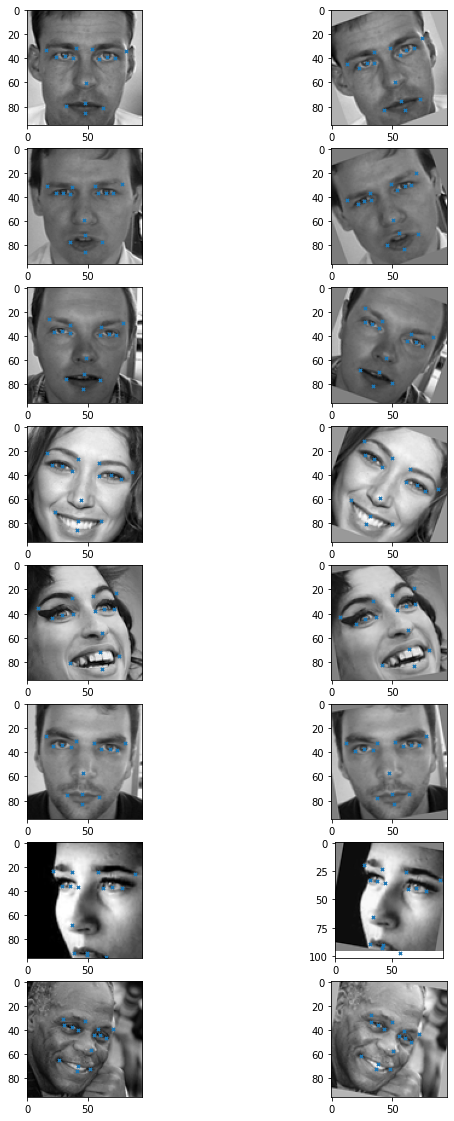

In [7]:
# Rotation
rotation_set = da.create_augs_from_transform(autoFillTrain, da.rotate, params=[20, -20, 10, -10])
vs.rand_vis_compare_orig_augset(train_dataset, rotation_set, 2)

In [8]:
all_datasets = []

all_datasets += [train_dataset]
all_datasets += mirror_set
all_datasets += noise_set
all_datasets += brightTrim_set
all_datasets += rotation_set

print('Num of datasets after augmentation: {}'.format(len(all_datasets)))

print('Concatenating all sets...')
train_datasets = torch.utils.data.ConcatDataset(all_datasets)
print('Num of samples after concatenation: {}'.format(len(train_datasets)))

Num of datasets after augmentation: 10
Concatenating all sets...
Num of samples after concatenation: 18190


In [9]:
# Init samplers and loaders
train_sampler = SubsetRandomSampler(range(len(train_datasets)))
val_sampler = SubsetRandomSampler(range(len(val_dataset)))

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=150, sampler=train_sampler, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=150, sampler=val_sampler, num_workers=4)

print('Size of training loader batches: {}\nSize of validation loader batches: {}'.format(len(train_loader), len(val_loader)))

Size of training loader batches: 122
Size of validation loader batches: 3


In [10]:
# Nets
fc_model = model.FullyConnectedNet()
resnet32_model = model.resnet32()
resnet47_model = model.resnet47()

In [11]:
# Optimizer and scheduler Inits
lr = 2e-2
optimizer = optim.Adam(resnet47_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)

In [12]:
train.train_model(resnet47_model, optimizer, train_loader, val_loader, scheduler=scheduler, loss_fn=train.RMSELoss, to_mask=True, epochs=50)

Using Device - cuda
Starting Epoch: 1/50 
Train Mode Set to True.
Starting the first batch...
Iteration - 1:  Average Training Loss: 50.9631
Iteration - 31:  Average Training Loss: 11.5791
Iteration - 61:  Average Training Loss: 8.1783
Iteration - 91:  Average Training Loss: 6.9921
Iteration - 121:  Average Training Loss: 6.4000
Evaluating..
Average Training Loss: 6.3861 Average Val Loss: 3.1319
Improvement Detected, Saving to ./best_model.pt
Starting Epoch: 2/50 
Train Mode Set to True.
Starting the first batch...
Iteration - 1:  Average Training Loss: 4.1563
Iteration - 31:  Average Training Loss: 4.5548
Iteration - 61:  Average Training Loss: 4.5659
Iteration - 91:  Average Training Loss: 4.5874
Iteration - 121:  Average Training Loss: 4.5886
Evaluating..
Average Training Loss: 4.5891 Average Val Loss: 3.2519
Starting Epoch: 3/50 
Train Mode Set to True.
Starting the first batch...
Iteration - 1:  Average Training Loss: 4.6893
Iteration - 31:  Average Training Loss: 4.4978
Iteration

KeyboardInterrupt: 